Cargados: 96 Fe, 16 Nd  (total 112)
Calculado dmat (distancias euclidianas) en 0.000 s
Realizando sanity checks (comparación ΔE vs ΔE exacta) ...
Sanity checks pasaron.
Inicial E=-35.516566, T0~1.953087, alpha=0.99980242, use_neighbors=False
Step 10000/50000  E=-54.388573  Best=-55.670330  T=2.708e-01
Step 20000/50000  E=-55.981237  Best=-55.981237  T=3.753e-02
Step 30000/50000  E=-55.981237  Best=-55.981237  T=5.203e-03
Step 40000/50000  E=-55.981237  Best=-55.981237  T=7.213e-04
Step 50000/50000  E=-55.981237  Best=-55.981237  T=1.000e-04
Aceptaciones: 3370/50000 = 6.74%
SA completado en 11.26 s
Mejor energía encontrada: -55.981237
Índices Fe -> Ti (0-based): [0, 1, 11, 21, 31, 34, 46, 78]
Guardado índices: ./outputs_euclid\ti_best_indices.txt
Guardado configuración final (x y z TYPE): ./outputs_euclid\final_configuration_with_types.txt
Guardado CSV: ./outputs_euclid\final_configuration_with_types.csv
Distancia promedio Ti - Nd: 4.2571
Distancia promedio Ti - Ti: 5.0571


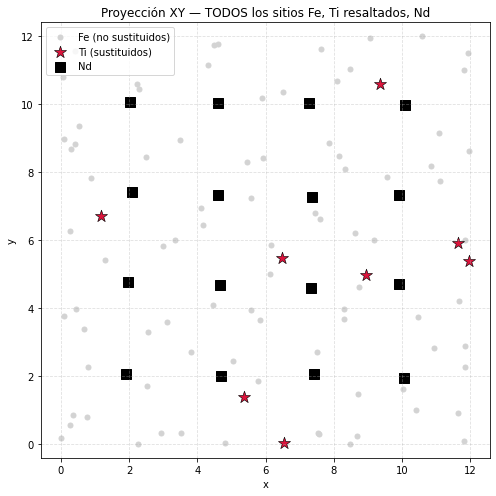

Guardada figura XY: ./outputs_euclid\projection_xy_all_atoms_euclid.png


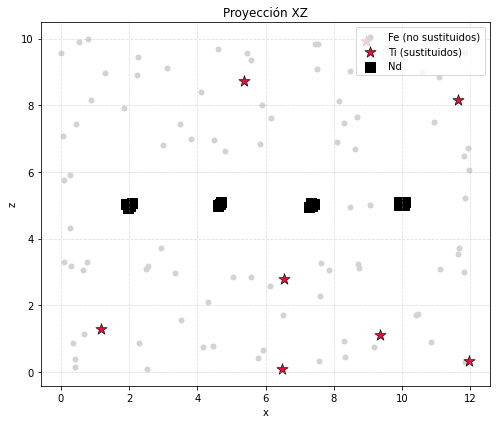

Guardada figura XZ: ./outputs_euclid\projection_xz_all_atoms_euclid.png


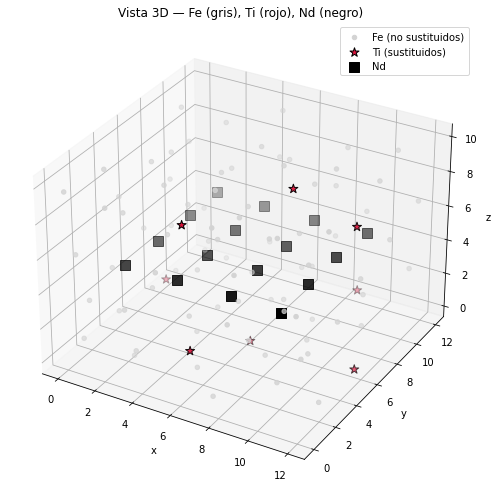

Guardada figura 3D: ./outputs_euclid\projection_3d_all_atoms_euclid.png

Ejecución finalizada. Archivos en: ./outputs_euclid


In [3]:
#!/usr/bin/env python3
"""
Simulated annealing — sustituir N_Ti sitios Fe -> Ti (DISTANCIA EUCLIDIANA)
- Usa distancia euclidiana simple entre coordenadas (sin PBC).
- Por defecto calcula todas las parejas (dmat completo).
- Opcional: activar cutoff para usar lista de vecinos (más escalable).
- Incluye sanity checks que comparan delta_energy_swap con diferencia exacta de energía.
- Grafica TODOS los Fe y Nd, resaltando los Fe sustituidos (Ti).
Requisitos: numpy, matplotlib, pandas
"""

import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os

# ------------------ Rutas / Salida ------------------
FE_FILE = "./Fe_positions_v2.txt"
ND_FILE = "./Nd_positions_v2.txt"
OUT_DIR = "./outputs_euclid"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ Parámetros Morse (según tu PDF) ------------------
MORSE_PARAMS = {
    ("Fe","Fe"): (0.764, 1.5995, 2.7361),
    ("Fe","Nd"): (0.6036, 1.6458, 3.188),
    ("Nd","Nd"): (0.312, 0.945, 4.092),
    ("Fe","Ti"): (0.8162, 1.448, 2.914),
    ("Nd","Ti"): (0.4964, 1.4401, 3.4309),
    ("Ti","Ti"): (0.6540, 1.2118, 3.3476),
}

def pair_params(t1, t2):
    key = (t1,t2)
    if key in MORSE_PARAMS:
        return MORSE_PARAMS[key]
    key = (t2,t1)
    if key in MORSE_PARAMS:
        return MORSE_PARAMS[key]
    raise KeyError(f"No hay parámetros para {t1}-{t2}")

def morse_energy(r, params):
    D0, alpha, r0 = params
    x = math.exp(-alpha*(r - r0))
    return D0*(x*x - 2*x)

# ------------------ Cargar posiciones ------------------
fe_positions = np.loadtxt(FE_FILE)   # shape (n_fe,3)
nd_positions = np.loadtxt(ND_FILE)   # shape (n_nd,3)
n_fe = fe_positions.shape[0]
n_nd = nd_positions.shape[0]
all_positions = np.vstack([fe_positions, nd_positions])  # 0..n_fe-1 Fe sites, n_fe.. Nd
N_total = all_positions.shape[0]
print(f"Cargados: {n_fe} Fe, {n_nd} Nd  (total {N_total})")

# ------------------ Parámetros de ejecución (ajustables) ------------------
N_Ti = 8            # número de sustituciones Fe -> Ti
N_STEPS = 50000     # pasos de SA
SEED = 2025
RECORD_EVERY = 50
USE_CUTOFF = False  # si True, usa cutoff y lista de vecinos
CUTOFF = 8.0        # Å, solo usado si USE_CUTOFF=True
SANITY_TESTS = 10   # número de pruebas de sanity check al inicio

# ------------------ Distancias euclidianas (dmat) ------------------
start = time.time()
diff = all_positions[:, None, :] - all_positions[None, :, :]
dmat = np.linalg.norm(diff, axis=2)  # Euclidean distances (sin PBC)
print(f"Calculado dmat (distancias euclidianas) en {time.time()-start:.3f} s")

# ------------------ Opcional: construir lista de vecinos si USE_CUTOFF True ------------------
if USE_CUTOFF:
    neighbors = [[] for _ in range(N_total)]
    for i in range(N_total):
        for j in range(i+1, N_total):
            if dmat[i,j] <= CUTOFF:
                neighbors[i].append(j)
                neighbors[j].append(i)
    print(f"Lista de vecinos construida con cutoff={CUTOFF} Å")
else:
    neighbors = None  # indicará que iteramos sobre todos los átomos cuando sea necesario

# ------------------ Helpers de tipos ------------------
def type_at_index(idx, ti_set):
    if idx >= n_fe:
        return "Nd"
    return "Ti" if idx in ti_set else "Fe"

# ------------------ Energía total (suma i<j usando dmat) ------------------
def total_energy(ti_indices, use_neighbors=False):
    ti_set = set(ti_indices)
    E = 0.0
    if use_neighbors and neighbors is not None:
        # sumar solo sobre neighbor lists (cada par una vez)
        seen = set()
        for i in range(N_total):
            for j in neighbors[i]:
                if j <= i: 
                    continue
                ti = type_at_index(i, ti_set)
                tj = type_at_index(j, ti_set)
                params = pair_params(ti if ti!="Nd" else "Nd", tj if tj!="Nd" else "Nd")
                E += morse_energy(dmat[i,j], params)
    else:
        for i in range(N_total):
            ti = type_at_index(i, ti_set)
            for j in range(i+1, N_total):
                tj = type_at_index(j, ti_set)
                params = pair_params(ti if ti!="Nd" else "Nd", tj if tj!="Nd" else "Nd")
                E += morse_energy(dmat[i,j], params)
    return E

# ------------------ ΔE para swap (i in ti_set, j not in ti_set) ------------------
def delta_energy_swap(i, j, ti_set, use_neighbors=False):
    assert i in ti_set and j not in ti_set
    type_i_old = "Ti"; type_j_old = "Fe"
    type_i_new = "Fe"; type_j_new = "Ti"
    delta = 0.0

    # elegir lista de k a iterar: si usamos neighbors, tomamos union(neigh[i], neigh[j]), else todos k != i,j
    if use_neighbors and neighbors is not None:
        ks = set(neighbors[i]) | set(neighbors[j])
    else:
        ks = set(range(N_total))
    ks.discard(i); ks.discard(j)

    for k in ks:
        tk = type_at_index(k, ti_set)
        params_ik_old = pair_params(type_i_old if type_i_old!="Nd" else "Nd", tk if tk!="Nd" else "Nd")
        params_jk_old = pair_params(type_j_old if type_j_old!="Nd" else "Nd", tk if tk!="Nd" else "Nd")
        E_old = morse_energy(dmat[i,k], params_ik_old) + morse_energy(dmat[j,k], params_jk_old)
        params_ik_new = pair_params(type_i_new if type_i_new!="Nd" else "Nd", tk if tk!="Nd" else "Nd")
        params_jk_new = pair_params(type_j_new if type_j_new!="Nd" else "Nd", tk if tk!="Nd" else "Nd")
        E_new = morse_energy(dmat[i,k], params_ik_new) + morse_energy(dmat[j,k], params_jk_new)
        delta += (E_new - E_old)

    # par i-j
    params_ij_old = pair_params(type_i_old if type_i_old!="Nd" else "Nd", type_j_old if type_j_old!="Nd" else "Nd")
    params_ij_new = pair_params(type_i_new if type_i_new!="Nd" else "Nd", type_j_new if type_j_new!="Nd" else "Nd")
    delta += (morse_energy(dmat[i,j], params_ij_new) - morse_energy(dmat[i,j], params_ij_old))
    return delta

# ------------------ Sanity check function ------------------
def sanity_check_swap(i, j, ti_set, tol=1e-8, use_neighbors=False):
    E_before = total_energy(ti_set, use_neighbors=use_neighbors)
    dE = delta_energy_swap(i, j, ti_set, use_neighbors=use_neighbors)
    new_ti = set(ti_set)
    new_ti.remove(i); new_ti.add(j)
    E_after = total_energy(new_ti, use_neighbors=use_neighbors)
    diff = (E_before + dE) - E_after
    if abs(diff) > tol:
        print("SANITY CHECK FAILED: i,j=", i, j, " diff=", diff)
        return False
    return True

# ------------------ Inicialización y T0 estimation ------------------
def random_initial_ti(n_ti=8, seed=42):
    rng = random.Random(seed)
    return set(rng.sample(range(n_fe), n_ti))

def estimate_T0(ti_set, samples=300, seed=1, use_neighbors=False):
    rng = random.Random(seed)
    deltas = []
    for _ in range(samples):
        i = rng.choice(list(ti_set))
        j = rng.choice([x for x in range(n_fe) if x not in ti_set])
        dE = delta_energy_swap(i, j, ti_set, use_neighbors=use_neighbors)
        deltas.append(abs(dE))
    avg = np.mean(deltas) if len(deltas)>0 else 1.0
    return max(1e-8, avg), deltas

# ------------------ SA principal ------------------
def simulated_annealing(n_ti=8, n_steps=50000, seed=123, record_every=100, use_neighbors=False, verbose=True):
    random.seed(seed)
    ti_set = random_initial_ti(n_ti, seed=seed)
    E = total_energy(ti_set, use_neighbors=use_neighbors)
    best_E = E; best_ti = set(ti_set)
    energies = []; steps = []
    T0, _ = estimate_T0(ti_set, samples=300, seed=seed+1, use_neighbors=use_neighbors)
    T_final = 1e-4
    alpha = (T_final / T0) ** (1.0 / max(1, n_steps))
    T = T0
    if verbose:
        print(f"Inicial E={E:.6f}, T0~{T0:.6f}, alpha={alpha:.8f}, use_neighbors={use_neighbors}")
    accept_count = 0
    for step in range(1, n_steps+1):
        i = random.choice(list(ti_set))
        j = random.choice([x for x in range(n_fe) if x not in ti_set])
        dE = delta_energy_swap(i, j, ti_set, use_neighbors=use_neighbors)
        if dE <= 0.0 or random.random() < math.exp(-dE / T):
            # aceptar
            ti_set.remove(i); ti_set.add(j)
            E += dE
            accept_count += 1
            if E < best_E:
                best_E = E; best_ti = set(ti_set)
        T *= alpha
        if step % record_every == 0:
            energies.append(E); steps.append(step)
        if verbose and step % (n_steps//5 if n_steps>=5 else 1) == 0:
            print(f"Step {step}/{n_steps}  E={E:.6f}  Best={best_E:.6f}  T={T:.3e}")
    if verbose:
        print(f"Aceptaciones: {accept_count}/{n_steps} = {100*accept_count/n_steps:.2f}%")
    return {"best_E": best_E, "best_ti": best_ti, "final_E": E, "final_ti": ti_set,
            "energies": np.array(energies), "steps": np.array(steps), "T0": T0, "alpha": alpha}

# ------------------ Ejecutar: sanity checks y corrida ------------------
if __name__ == "__main__":
    t0 = time.time()
    result = None

    # Inicial config temporal para sanity checks
    ti_init = random_initial_ti(N_Ti, seed=SEED)
    print("Realizando sanity checks (comparación ΔE vs ΔE exacta) ...")
    passed = True
    for s in range(SANITY_TESTS):
        i = random.choice(list(ti_init))
        j = random.choice([x for x in range(n_fe) if x not in ti_init])
        ok = sanity_check_swap(i, j, ti_init, tol=1e-6, use_neighbors=USE_CUTOFF)
        if not ok:
            passed = False
            break
    if not passed:
        print("Sanity checks fallaron. Revisa implementación de ΔE o parámetros.")
    else:
        print("Sanity checks pasaron.")

    # Ejecutar SA (usa neighbors si USE_CUTOFF True)
    result = simulated_annealing(n_ti=N_Ti, n_steps=N_STEPS, seed=SEED, record_every=RECORD_EVERY,
                                 use_neighbors=USE_CUTOFF, verbose=True)
    elapsed = time.time() - t0
    print(f"SA completado en {elapsed:.2f} s")

    best_ti = sorted(list(result["best_ti"]))
    best_ti_set = set(best_ti)
    print("Mejor energía encontrada: {:.6f}".format(result["best_E"]))
    print("Índices Fe -> Ti (0-based):", best_ti)

    # ------------------ Guardar indices y configuración (solo Fe->Ti) ------------------
    idx_path = os.path.join(OUT_DIR, "ti_best_indices.txt")
    with open(idx_path, "w") as f:
        f.write(",".join(map(str,best_ti)))
    print(f"Guardado índices: {idx_path}")

    # Vector types: primeras n_fe posiciones son Fe o Ti (según best_ti), las últimas son Nd
    types = ["Ti" if (i < n_fe and i in best_ti_set) else ("Fe" if i < n_fe else "Nd") for i in range(N_total)]
    final_path = os.path.join(OUT_DIR, "final_configuration_with_types.txt")
    with open(final_path, "w") as f:
        for i,pos in enumerate(all_positions):
            f.write(f"{pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f} {types[i]}\n")
    print(f"Guardado configuración final (x y z TYPE): {final_path}")

    df = pd.DataFrame({"x": all_positions[:,0], "y": all_positions[:,1], "z": all_positions[:,2], "type": types})
    csv_path = os.path.join(OUT_DIR, "final_configuration_with_types.csv")
    df.to_csv(csv_path, index=False)
    print(f"Guardado CSV: {csv_path}")

    # ------------------ Métricas ------------------
    def compute_metrics_simple(ti_indices):
        pos = fe_positions[list(ti_indices)]
        dist_Ti_Nd = [np.min(np.linalg.norm(nd_positions - p, axis=1)) for p in pos]
        dist_Ti_Ti = []
        for i,p in enumerate(pos):
            if len(pos) == 1:
                dist_Ti_Ti.append(np.nan)
                continue
            d = np.linalg.norm(pos - p, axis=1)
            d[i] = np.inf
            dist_Ti_Ti.append(np.min(d))
        return np.array(dist_Ti_Nd), np.array(dist_Ti_Ti)

    if len(best_ti) > 0:
        dTiNd, dTiTi = compute_metrics_simple(best_ti)
        print(f"Distancia promedio Ti - Nd: {np.nanmean(dTiNd):.4f}")
        print(f"Distancia promedio Ti - Ti: {np.nanmean(dTiTi):.4f}")
    else:
        print("No hay Ti en la mejor configuración (esto no debería ocurrir).")

    # ------------------ FIGURAS: todos los átomos (Fe, resaltado Ti, Nd) ------------------
    fe_non_ti_idx = [i for i in range(n_fe) if i not in best_ti_set]
    fe_non_ti_pos = fe_positions[fe_non_ti_idx]
    ti_pos = fe_positions[best_ti] if len(best_ti)>0 else np.empty((0,3))

    # XY
    plt.figure(figsize=(7,7))
    if fe_non_ti_pos.size > 0:
        plt.scatter(fe_non_ti_pos[:,0], fe_non_ti_pos[:,1], s=25, color="lightgray", label="Fe (no sustituidos)")
    if ti_pos.size > 0:
        plt.scatter(ti_pos[:,0], ti_pos[:,1], s=160, marker="*", edgecolor="k", linewidth=0.6, color="crimson", label="Ti (sustituidos)")
    plt.scatter(nd_positions[:,0], nd_positions[:,1], s=120, marker="s", color="black", label="Nd")
    plt.xlabel("x"); plt.ylabel("y"); plt.title("Proyección XY — TODOS los sitios Fe, Ti resaltados, Nd")
    plt.axis("equal"); plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    path_xy = os.path.join(OUT_DIR, "projection_xy_all_atoms_euclid.png")
    plt.tight_layout(); plt.savefig(path_xy, dpi=200); plt.show()
    print(f"Guardada figura XY: {path_xy}")

    # XZ
    plt.figure(figsize=(7,6))
    if fe_non_ti_pos.size > 0:
        plt.scatter(fe_non_ti_pos[:,0], fe_non_ti_pos[:,2], s=25, color="lightgray", label="Fe (no sustituidos)")
    if ti_pos.size > 0:
        plt.scatter(ti_pos[:,0], ti_pos[:,2], s=140, marker="*", edgecolor="k", linewidth=0.6, color="crimson", label="Ti (sustituidos)")
    plt.scatter(nd_positions[:,0], nd_positions[:,2], s=110, marker="s", color="black", label="Nd")
    plt.xlabel("x"); plt.ylabel("z"); plt.title("Proyección XZ")
    plt.grid(True, linestyle="--", alpha=0.4); plt.legend()
    path_xz = os.path.join(OUT_DIR, "projection_xz_all_atoms_euclid.png")
    plt.tight_layout(); plt.savefig(path_xz, dpi=200); plt.show()
    print(f"Guardada figura XZ: {path_xz}")

    # 3D
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    if fe_non_ti_pos.size > 0:
        ax.scatter(fe_non_ti_pos[:,0], fe_non_ti_pos[:,1], fe_non_ti_pos[:,2], s=20, color="lightgray", label="Fe (no sustituidos)")
    if ti_pos.size > 0:
        ax.scatter(ti_pos[:,0], ti_pos[:,1], ti_pos[:,2], s=90, marker="*", color="crimson", edgecolor="k", label="Ti (sustituidos)")
    ax.scatter(nd_positions[:,0], nd_positions[:,1], nd_positions[:,2], s=100, marker="s", color="black", label="Nd")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.set_title("Vista 3D — Fe (gris), Ti (rojo), Nd (negro)")
    ax.legend()
    path_3d = os.path.join(OUT_DIR, "projection_3d_all_atoms_euclid.png")
    plt.tight_layout(); plt.savefig(path_3d, dpi=200); plt.show()
    print(f"Guardada figura 3D: {path_3d}")

    print("\nEjecución finalizada. Archivos en:", OUT_DIR)
